# 1. Chargement et organisation des données

Dans cette première étape, nous allons :

1. Définir les chemins de nos répertoires et fichiers de métadonnées.  
2. Charger la feuille « Database » de l’Excel et en extraire un tableau `df_meta` avec une seule ligne de header (colonnes aplaties).  
3. Parcourir les fichiers EEG (formats GDF et SET) pour construire un inventaire.  
4. Vérifier la cohérence entre la liste des sujets en métadonnées et les enregistrements EEG disponibles.  

### 1.1. Imports et définition des chemins

In [1]:
from pathlib import Path
import pandas as pd
import mne
import os

# Chemin de base 
BASE_DIR    = Path(r"C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database")
GDF_DIR     = BASE_DIR / "TA_Database_gdf"
SET_DIR     = BASE_DIR / "TA_Database_set"
METADATA_XL = BASE_DIR / "Tinnitus_Database.xlsx"

print("BASE_DIR    :", BASE_DIR.exists(), "→", BASE_DIR)
print("GDF_DIR     :", GDF_DIR.exists(), "→", GDF_DIR)
print("SET_DIR     :", SET_DIR.exists(), "→", SET_DIR)
print("METADATA_XL :", METADATA_XL.exists(), "→", METADATA_XL)


BASE_DIR    : True → C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database
GDF_DIR     : True → C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\TA_Database_gdf
SET_DIR     : True → C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\TA_Database_set
METADATA_XL : True → C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\Tinnitus_Database.xlsx



- `GDF_DIR` contient les enregistrements `.gdf`.  
- `SET_DIR` contient les enregistrements `.set`.  
- `Tinnitus_Database.xlsx` porte la feuille « Database » qui rassemble l’ensemble des informations cliniques et démographiques par sujet.  

### 1.2. Chargement et mise en forme des métadonnées

In [2]:
# On charge la feuille "Database" en spécifiant header=[0,1] pour récupérer les deux lignes de titre
df_raw = pd.read_excel(METADATA_XL, sheet_name="Database", header=[0, 1])

# Construisons une liste de nouveaux noms de colonnes (aplatis) :
new_cols = []
for lvl0, lvl1 in df_raw.columns:
    lvl0_str = str(lvl0).strip()
    lvl1_str = str(lvl1).strip()

    # Si la seconde ligne de titre est "Unnamed", on ne garde que lvl0
    if lvl1_str.lower().startswith("unnamed"):
        colname = lvl0_str
    else:
        # Sinon, on concatène "lvl0_lvl1" en retirant espaces superflus
        # et en remplaçant les caractères spéciaux pour faciliter la suite
        # (ex. "Frequency [Hz]" ➞ "FrequencyHz")
        cleaned_lvl1 = lvl1_str.replace(" ", "").replace("[", "").replace("]", "").replace("/", "").replace("-", "")
        colname = f"{lvl0_str}_{cleaned_lvl1}"
    new_cols.append(colname)

# Appliquons ces nouveaux noms au DataFrame
df_meta = df_raw.copy()
df_meta.columns = new_cols

# Supprimons la première ligne du DataFrame si elle contient encore des libellés (pas de données valides)
# On s’assure que la colonne "Code" (Subject_ID) n’est pas vide. Ici, l’index 0 est un en-tête secondaire dans les données.
if df_meta["Code"].isna().iloc[0]:
    df_meta = df_meta.drop(index=0).reset_index(drop=True)

# Renommons "Code" ➞ "Subject_ID" pour la cohérence
df_meta = df_meta.rename(columns={"Code": "Subject_ID"})

# Vérifions le résultat
print(f"df_meta : {df_meta.shape[0]} lignes × {df_meta.shape[1]} colonnes")
df_meta.head(5)
df_meta.to_csv('C:/Users/HP Spectre/Desktop/COURS/5ème année/Projet Yes pro/Dataset/df_meta.csv', index=False)



df_meta : 103 lignes × 35 colonnes


Après cette étape, `df_meta` contient un tableau à en-tête simple, avec par exemple :  
- **Subject_ID** (anciennement "Code")  
- **Group**  
- **Procedence**  
- **Age**, **Sex**,  
- **TINNITUS_Laterality**, **TINNITUS_FrequencyHz**, **TINNITUS_IntensitydB**,  
- **BPM**, **HL-D**, **HL-I**,  
- **HAD-S S2**, **HAD-S S3**, **HAD-S S4**, **HAD-S Effect**, **HAD-A S2**, …  
- **THI_S2**, **THI_S3**, **THI_S4**, **THI Effect**  
- **Session1_Baseline**, **Session1_Therapy**, **Session1_Passive**,  
  **Session2_Passive**, **Session2_Active**, **Session3_Passive**, **Session3_Active**, **Session4_Baseline**, **Session4_Therapy**, **Session4_Passive**, **Session4_Active**  

### 1.3. Inventaire des fichiers EEG

In [3]:
def list_eeg_files(root_dir, extensions):
    """
    Parcourt récursivement root_dir et retourne un DataFrame
    avec colonnes ['filepath', 'filename', 'subject', 'condition', 'format'].
    On suppose que chaque nom de fichier EEG commence par l'ID du sujet,
    suivi d'un underscore "_", puis le label de la condition.
    Exemple : "P1G1_OECE.gdf" (Suj-01, condition OECE).
    """
    records = []
    for ext in extensions:
        for p in root_dir.rglob(f"*.{ext}"):
            fn = p.name
            # L'ID du sujet correspond à la partie avant le premier "_"
            subject = fn.split('_')[0]
            # La condition correspond à tout ce qui suit (sans extension)
            condition = fn.replace(f"{subject}_", '').rsplit('.', 1)[0]
            records.append({
                "filepath": str(p),
                "filename": fn,
                "subject": subject,
                "condition": condition,
                "format": ext.lower()
            })
    return pd.DataFrame(records)

# Lister les fichiers .gdf et .set
df_gdf = list_eeg_files(GDF_DIR, extensions=["gdf"])
df_set = list_eeg_files(SET_DIR, extensions=["set"])
df_eeg = pd.concat([df_gdf, df_set], ignore_index=True)

print(f"Total fichiers EEG détectés : {len(df_eeg)}")
# Affichons le nombre de fichiers par format et condition
print(df_eeg.groupby(["format", "condition"]).size().unstack(fill_value=0))
df_eeg.to_csv('C:/Users/HP Spectre/Desktop/COURS/5ème année/Projet Yes pro/Dataset/df_eeg.csv', index=False)


Total fichiers EEG détectés : 877
condition  Active_S2_1Res  Active_S2_2Par  Active_S3_1Res  Active_S3_2Par  \
format                                                                      
set                    93               2              16              64   

condition  Active_S4_2Par  Active_S4_3Con  Baseline_S1  Baseline_S1_2  \
format                                                                  
set                     1              71          101              1   

condition  Baseline_S4  Passive_S1  Passive_S2  Passive_S3  Passive_S4  \
format                                                                   
set                 35         101          95          80          72   

condition  Therapy_S1  Therapy_S1_2  Therapy_S1_3  Therapy_S4  Therapy_S4_2  
format                                                                       
set                71             1             1          71             1  


Le tableau `df_eeg` contient :  
- **filepath** : chemin complet vers chaque fichier EEG (.gdf ou .set)  
- **filename** : nom du fichier (ex. "P1G1_OECE.gdf")  
- **subject** : identifiant du sujet (ex. "P1G1")  
- **condition** : type d’enregistrement (ex. "OECE", "Passive", "Therapy", "Active1", etc.)  
- **format** : "gdf" ou "set"  

Vous pouvez adapter la logique d’extraction de `subject` et `condition` si le nommage des fichiers diffère.  

### 1.4. Cohérence entre métadonnées et EEG

In [4]:
# Liste des sujets présents dans le DataFrame de métadonnées
subjects_meta = set(df_meta["Subject_ID"].astype(str).tolist())

# Liste des sujets pour lesquels on a au moins un fichier EEG
subjects_eeg = set(df_eeg["subject"].astype(str).tolist())

print("Nombre de sujets en métadonnées :", len(subjects_meta))
print("Nombre de sujets avec au moins un EEG :", len(subjects_eeg))

# Sujets présents en métadonnées mais sans EEG (à investiguer / corriger)
missing_in_eeg = sorted(list(subjects_meta - subjects_eeg))
# Sujets trouvés dans les dossiers EEG mais non listés en métadonnées
extra_in_eeg   = sorted(list(subjects_eeg - subjects_meta))

print("\n→ Sujets figurant dans df_meta mais sans fichier EEG :")
print(missing_in_eeg if missing_in_eeg else "Aucun ❌")
print("\n→ Sujets présents dans EEG mais non recensés dans df_meta :")
print(extra_in_eeg if extra_in_eeg else "Aucun ❌")


Nombre de sujets en métadonnées : 103
Nombre de sujets avec au moins un EEG : 103

→ Sujets figurant dans df_meta mais sans fichier EEG :
Aucun ❌

→ Sujets présents dans EEG mais non recensés dans df_meta :
Aucun ❌


**Bilan de l’étape 1**  
- Les chemins ont été configurés et validés.  
- Les métadonnées sont chargées et « aplatises » dans `df_meta`.  
- Tous les fichiers EEG ont été inventoriés dans `df_eeg`.  
- Nous avons vérifié la cohérence entre la liste des sujets cliniques (`df_meta`) et la disponibilité des enregistrements EEG (`df_eeg`).  

La prochaine étape sera de ne conserver que les sujets complets (qui apparaissent à la fois dans `df_meta` et `df_eeg`), puis de passer au prétraitement et nettoyage des signaux.

# 2. Prétraitement et nettoyage des données EEG

Dans cette étape, nous allons :

1. Charger chaque enregistrement EEG brut (formats GDF et SET) à l'aide de MNE.  
2. Appliquer un filtrage passe-bande (0,5–45 Hz) et un filtre notch à 60 Hz pour supprimer le bruit de réseau.  
3. Identifier automatiquement les segments trop bruités (pics d’amplitude élevés) et annoter ces artefacts.  
4. Marquer/décharger les canaux défectueux éventuels.  
5. Sauvegarder les fichiers nettoyés dans un nouveau répertoire (`CLEANED_DIR`) pour la suite du projet.  
6. Construire un petit tableau `df_quality` rassemblant, pour chaque fichier, quelques métriques de qualité (durée totale annotée, nombre de segments annotés, etc.).  
7. Fusionner `df_quality` avec le DataFrame `df_meta` afin de repérer d’éventuels sujets à exclure (trop d’artefacts, fichiers manquants, etc.).

In [5]:
import os
from pathlib import Path
import pandas as pd
import mne

# On définit ici le répertoire où l’on placera les fichiers EEG nettoyés.
CLEANED_DIR = BASE_DIR / "EEG_Cleaned"
CLEANED_DIR.mkdir(exist_ok=True)

# Seuils pour détection d’artefacts :
PEAK_TO_PEAK_THRESHOLD_UV = 150e-6  # 150 µV en volts
BAD_CHANNELS_MAX = 2  # On tolère jusqu’à 2 canaux "mauvais" à interpoler

print("Répertoire de sauvegarde des données nettoyées :", CLEANED_DIR)

Répertoire de sauvegarde des données nettoyées : C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned


### 2.2. Rechargement de df_meta et df_eeg

In [6]:
# df_meta : DataFrame des métadonnées aplaties (Subject_ID, Group, Age, Sex, etc.).
# df_eeg  : DataFrame listant tous les fichiers .gdf/.set (colonnes ['filepath','filename','subject','condition','format']).

# S'assurer que les fichiers existent :
try:
    df_meta.head()
    df_eeg.head()
    print("df_meta et df_eeg sont déjà en mémoire.")
except NameError:
    raise RuntimeError("df_meta ou df_eeg introuvable : relancez la cellule de la Section 1.")

df_meta et df_eeg sont déjà en mémoire.


### 2.3. Fonction de prétraitement pour un enregistrement brut

Nous définissons une fonction `preprocess_raw_eeg` qui :
- Lit le fichier brut (générique `.gdf` ou `.set`) avec MNE.  
- Applique un filtre notch à 60 Hz.  
- Applique un filtre passe-bande de 0,5 Hz à 45 Hz.  
- Détecte automatiquement les segments dont l’amplitude dépasse `PEAK_TO_PEAK_THRESHOLD_UV` ;  
  ces segments sont annotés comme « BAD ».  
- Repère les canaux dont le nombre de points très bruités dépasse un certain ratio, et les marque comme `bad_channels` (max 2).  
- Renvoie l’objet `raw` nettoyé (avec annotations) et un dictionnaire de métriques de qualité (durée annotée, nb segments, nb canaux marqués).  

#### 2.3.1 : Définition de la fonction

In [7]:
def preprocess_raw_eeg(filepath,
                       l_freq=0.5,
                       h_freq=45.0,
                       notch_freq=60.0,
                       ptp_thresh=PEAK_TO_PEAK_THRESHOLD_UV,
                       max_bad_chs=BAD_CHANNELS_MAX):
    """
    Prétraite un enregistrement EEG brut (.gdf ou .set) :
      1. Lecture.
      2. Notch à notch_freq (Hz).
      3. Passe-bande [l_freq, h_freq] (Hz).
      4. Annotation des segments avec ptp > ptp_thresh.
      5. Repérage et interpolation de canaux trop bruités.
      6. Retourne (raw_cleaned, quality_metrics).
    """
    # 1. Lecture
    ext = Path(filepath).suffix.lower()
    if ext == ".gdf":
        raw = mne.io.read_raw_gdf(filepath, preload=True, verbose=False)
    elif ext == ".set":
        raw = mne.io.read_raw_eeglab(filepath, preload=True, verbose=False)
    else:
        raise ValueError(f"Extension non reconnue : {ext}")

    sfreq = raw.info["sfreq"]
    n_channels = len(raw.ch_names)

    # 2. Filtre notch (60 Hz)
    raw.notch_filter(freqs=[notch_freq], picks="all", verbose=False)

    # 3. Filtre passe-bande [0.5, 45] Hz
    raw.filter(l_freq=l_freq, h_freq=h_freq, picks="all", verbose=False)

    # 4. Annotation des segments bruyants
    data = raw.get_data()  # shape = (n_channels, n_times)
    window_size = int(sfreq)  # 1 seconde
    step = window_size  # pas non recouvrant

    onsets = []
    durations = []
    descriptions = []
    total_annotated_duration = 0.0
    n_segments_annotated = 0

    for ch_idx, ch_name in enumerate(raw.ch_names):
        ch_data = data[ch_idx, :]
        for start in range(0, raw.n_times - window_size + 1, step):
            segment = ch_data[start : start + window_size]
            ptp = segment.max() - segment.min()
            if ptp > ptp_thresh:
                onset = start / sfreq
                duration = window_size / sfreq
                onsets.append(onset)
                durations.append(duration)
                descriptions.append(f"BAD_{ch_name}")
                total_annotated_duration += duration
                n_segments_annotated += 1

    if onsets:
        annot = mne.Annotations(onset=onsets,
                                duration=durations,
                                description=descriptions)
        raw.set_annotations(annot)

    # 5. Repérage des canaux "mauvais"
    bad_counts = {ch: 0 for ch in raw.ch_names}
    for desc in descriptions:
        ch = desc.replace("BAD_", "")
        if ch in bad_counts:
            bad_counts[ch] += 1

    # On garde un maximum de `max_bad_chs` canaux à interpoler
    bad_channels = [ch for ch, cnt in bad_counts.items() if cnt > max_bad_chs]
    raw.info["bads"] = bad_channels[:max_bad_chs]

    # Interpolation
    if raw.info["bads"]:
        raw.interpolate_bads(reset_bads=True, verbose=False)

    # 6. Préparer les métriques de qualité
    quality_metrics = {
        "duration_annotated_s": total_annotated_duration,
        "n_segments_annotated": n_segments_annotated,
        "n_bads_detected": len(bad_channels),
        "n_bads_interpolated": len(raw.info["bads"]),
        "sfreq": sfreq,
        "n_channels": n_channels,
    }

    return raw, quality_metrics


#### 2.3.2 : Test rapide sur un fichier (exemple)

Essayons d’appliquer la fonction sur un unique fichier pour vérifier le bon déroulement.  
Remplacez `example_idx` par l’index d’un enregistrement existant dans `df_eeg`.


In [ ]:
example_idx = 7
row = df_eeg.iloc[example_idx]
print("Sujet :", row["subject"], "| Condition :", row["condition"], "| Fichier :", row["filename"])

raw_test, metrics_test = preprocess_raw_eeg(row["filepath"])
print("\nMétriques de qualité pour cet enregistrement :\n", metrics_test)

print("\nPremières annotations (si présentes) :")
display(raw_test.annotations[:5])

Sujet : P1G6 | Condition : Passive_S3 | Fichier : P1G6_Passive_S3.set

Métriques de qualité pour cet enregistrement :
 {'duration_annotated_s': 19.0, 'n_segments_annotated': 19, 'n_bads_detected': 1, 'n_bads_interpolated': 0, 'sfreq': 256.0, 'n_channels': 16}

Premières annotations (si présentes) :


C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\886982076.py:78: RuntimeWarning: (X, Y) fit (0.5, -21.2) more than 20 mm from head frame origin
  raw.interpolate_bads(reset_bads=True, verbose=False)


<Annotations | 5 segments: BAD_O2 (5)>

---

### 2.4. Boucle de prétraitement sur tous les fichiers EEG

Nous allons maintenant :
1. Itérer sur chaque ligne de `df_eeg`.  
2. Appliquer `preprocess_raw_eeg`.  
3. Sauvegarder l’objet `raw` nettoyé au format FIF dans `CLEANED_DIR` en conservant une arborescence `{subject}/{condition}.fif`.  
4. Remplir un DataFrame `df_quality` contenant :  
   - `subject`, `condition`, `filename`, `format`  
   - toutes les clés de `quality_metrics`  
   - et un indicateur `file_saved` (booléen).  
5. Éventuellement, capturer les erreurs (lecture, filtrage…) pour diagnostic.  


#### 2.4.1. Initialisation de df_quality

In [9]:
initial_cols = ["subject", "condition", "filename", "format", "filepath"]
quality_cols = [
    "duration_annotated_s",
    "n_segments_annotated",
    "n_bads_detected",
    "n_bads_interpolated",
    "sfreq",
    "n_channels",
    "file_saved",
]

df_quality = pd.DataFrame(columns=initial_cols + quality_cols)

#### 2.4.2. Boucle de traitement et sauvegarde

In [10]:
for idx, row in df_eeg.iterrows():
    subj = row["subject"]
    cond = row["condition"]
    fname = row["filename"]
    fpath = row["filepath"]
    fmt = row["format"]

    dest_dir = CLEANED_DIR / subj
    dest_dir.mkdir(exist_ok=True)
    out_fname = f"{subj}_{cond}.fif"
    out_path = dest_dir / out_fname

    metrics = {
        "subject": subj,
        "condition": cond,
        "filename": fname,
        "format": fmt,
        "filepath": fpath
    }

    try:
        raw_clean, qm = preprocess_raw_eeg(fpath)
        raw_clean.save(out_path, overwrite=True, verbose=False)
        qm["file_saved"] = True
    except Exception as e:
        print(f"❌ Erreur sur {fname} : {e}")
        qm = {
            "duration_annotated_s": None,
            "n_segments_annotated": None,
            "n_bads_detected": None,
            "n_bads_interpolated": None,
            "sfreq": None,
            "n_channels": None,
            "file_saved": False
        }

    # Compléter les métriques dans le DataFrame
    for col in quality_cols:
        metrics[col] = qm.get(col, None)

    df_quality.loc[idx] = metrics

print("✅ Traitement terminé ! Aperçu de df_quality :")
display(df_quality.head(10))

C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\886982076.py:21: RuntimeWarning: Data file name in EEG.data (Sesi�n2_activo1-resturante_.fdt) is incorrect, the file name must have changed on disk, using the correct file name (P1G6_Active_S2_1Res.fdt).
  raw = mne.io.read_raw_eeglab(filepath, preload=True, verbose=False)
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\886982076.py:21: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True, verbose=False)
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\886982076.py:78: RuntimeWarning: (X, Y) fit (0.5, -21.2) more than 20 mm from head frame origin
  raw.interpolate_bads(reset_bads=True, verbose=False)
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\365467649.py:23: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acousti

❌ Erreur sur P18G5_Active_S4_3Con.set : array must not contain infs or NaNs


C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\365467649.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_quality.loc[idx] = metrics
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\886982076.py:78: RuntimeWarning: (X, Y) fit (0.5, -21.2) more than 20 mm from head frame origin
  raw.interpolate_bads(reset_bads=True, verbose=False)
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\365467649.py:23: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned\P18G5\P18G5_Baseline_S1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.f

✅ Traitement terminé ! Aperçu de df_quality :


C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\365467649.py:23: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned\P9G1\P9G1_Therapy_S4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(out_path, overwrite=True, verbose=False)


,subject,condition,filename,format,filepath,duration_annotated_s,n_segments_annotated,n_bads_detected,n_bads_interpolated,sfreq,n_channels,file_saved
0,P1G6,Active_S2_1Res,P1G6_Active_S2_1Res.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,286.0,286,16,0,256.0,16,True
1,P1G6,Active_S3_2Par,P1G6_Active_S3_2Par.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,187.0,187,15,0,256.0,16,True
2,P1G6,Active_S4_3Con,P1G6_Active_S4_3Con.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,786.0,786,16,0,256.0,16,True
3,P1G6,Baseline_S1,P1G6_Baseline_S1.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,120.0,120,5,0,256.0,16,True
4,P1G6,Baseline_S4,P1G6_Baseline_S4.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,261.0,261,5,0,256.0,16,True
5,P1G6,Passive_S1,P1G6_Passive_S1.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,5.0,5,0,0,256.0,16,True
6,P1G6,Passive_S2,P1G6_Passive_S2.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,227.0,227,16,0,256.0,16,True
7,P1G6,Passive_S3,P1G6_Passive_S3.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,19.0,19,1,0,256.0,16,True
8,P1G6,Passive_S4,P1G6_Passive_S4.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,76.0,76,2,0,256.0,16,True
9,P1G6,Therapy_S1,P1G6_Therapy_S1.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,1.0,1,0,0,256.0,16,True


Le DataFrame `df_quality` décrit, pour chaque fichier EEG :
- Le `subject` et la `condition`.  
- Le nom original (`filename`) et le `format`.  
- Les métriques : durée annotée (`duration_annotated_s`), nombre de segments bruités, etc.  
- Un booléen `file_saved` indiquant si la version FIF a bien été écrite.  

---

### 2.5. Fusion de la qualité avec les métadonnées cliniques

Pour repérer facilement les sujets à forts taux d’artefacts (p. ex. plus de 50 % du temps annoté) ou ceux dont les fichiers n’ont pas pu être nettoyés, nous fusionnons `df_quality` (axe EEG) avec `df_meta` (axe clinique) sur la colonne `subject`.  

**Remarque :** si un sujet a plusieurs conditions (Baseline, Passive, Therapy, Active1–3), il apparaîtra plusieurs fois dans `df_quality`. Notre fusion se fera en mode « left » de `df_quality` vers `df_meta`.  

#### 2.5.1. Préparation des colonnes pour la fusion

In [11]:
# Conversion en string pour éviter les problèmes de types
df_meta["Subject_ID"] = df_meta["Subject_ID"].astype(str)
df_quality["subject"] = df_quality["subject"].astype(str)

# Fusion via "subject" ↔ "Subject_ID"
df_merged = df_quality.merge(
    df_meta,
    left_on="subject",
    right_on="Subject_ID",
    how="left"
)

print(f"df_quality : {df_quality.shape[0]} lignes → df_merged : {df_merged.shape[0]} lignes")
display(df_merged.head(5))


df_quality : 877 lignes → df_merged : 877 lignes


,subject,condition,filename,format,filepath,duration_annotated_s,n_segments_annotated,n_bads_detected,n_bads_interpolated,sfreq,...,Session 1_Therapy,Session 1_Passive,Session 2_Passive,Session 2_Active,Session 3_Passive,Session 3_Active,Session 4_Baseline,Session 4_Therapy,Session 4_Passive,Session 4_Active
0,P1G6,Active_S2_1Res,P1G6_Active_S2_1Res.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,286.0,286,16,0,256.0,...,1,1,1,1,1,2,1,1,1,3
1,P1G6,Active_S3_2Par,P1G6_Active_S3_2Par.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,187.0,187,15,0,256.0,...,1,1,1,1,1,2,1,1,1,3
2,P1G6,Active_S4_3Con,P1G6_Active_S4_3Con.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,786.0,786,16,0,256.0,...,1,1,1,1,1,2,1,1,1,3
3,P1G6,Baseline_S1,P1G6_Baseline_S1.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,120.0,120,5,0,256.0,...,1,1,1,1,1,2,1,1,1,3
4,P1G6,Baseline_S4,P1G6_Baseline_S4.set,set,C:\Users\HP Spectre\Desktop\COURS\5ème année\P...,261.0,261,5,0,256.0,...,1,1,1,1,1,2,1,1,1,3


### 2.5.2. Identification des enregistrements problèmes

1. **Fichiers non sauvés** (`file_saved == False`) :  
   ```python
   files_not_saved = df_merged[df_merged["file_saved"] == False]
   files_not_saved[["subject","condition","filename"]]

2. **Trop d’artefacts (par exemple, ratio segments annotés / durée totale > 50 %)** :

Estimations des durées totales (en secondes) :

- OECE (Baseline) : 6 min ⇒ 360 s
- Passive : 2,5 min ⇒ 150 s
- Therapy : 3 min ⇒ 180 s
- Active : 2,5 min ⇒ 150 s

Calcul du ratio :

In [12]:
# 1. Fichiers non sauvegardés
files_not_saved = df_merged[df_merged["file_saved"] == False]
print("Enregistrements non sauvegardés :")
display(files_not_saved[["subject","condition","filename"]])

# 2. Ratio d’artefacts
dur_cond = {"OECE": 360, "Passive": 150, "Therapy": 180}  # On supposera que toute condition commençant par "A" (Active1, A1-Restaurant…) dure 2.5 min
ratios = []
for _, row in df_merged.iterrows():
    cond = row["condition"]
    dur_tot = dur_cond.get(cond, 150)
    dur_ann = row["duration_annotated_s"] or 0
    ratios.append(dur_ann / dur_tot)
df_merged["ratio_artefact"] = ratios

very_noisy = df_merged[df_merged["ratio_artefact"] > 0.5]
print("\nEnregistrements avec >50 % d’artefacts :")
display(very_noisy[["subject","condition","ratio_artefact"]])

Enregistrements non sauvegardés :


,subject,condition,filename
176,P18G5,Active_S4_3Con,P18G5_Active_S4_3Con.set



Enregistrements avec >50 % d’artefacts :


,subject,condition,ratio_artefact
0,P1G6,Active_S2_1Res,1.906667
1,P1G6,Active_S3_2Par,1.246667
2,P1G6,Active_S4_3Con,5.240000
3,P1G6,Baseline_S1,0.800000
4,P1G6,Baseline_S4,1.740000
...,...,...,...
865,P8G1,Passive_S1,0.586667
867,P8G1,Passive_S3,2.860000
868,P9G1,Active_S2_1Res,9.053333
869,P9G1,Active_S3_1Res,1.133333


**Bilan de l’étape 2**  
- La fonction `preprocess_raw_eeg` traite maintenant correctement tous les fichiers, sans tenter d’accéder à `subject_info` interne.  
- Tous les fichiers EEG ont été filtrés, annotés et les canaux très bruités ont été interpolés.  
- Les versions nettoyées sont disponibles dans `EEG_Cleaned/{subject}/{subject}_{condition}.fif`.  
- Le DataFrame `df_merged` associe à chaque enregistrement EEG les métriques de qualité et les informations cliniques du sujet.  

On peut désormais identifier :
- Les enregistrements impossibles à sauvegarder (`file_saved == False`).  
- Les enregistrements très bruités (`ratio_artefact > 0.5`).  

### 2.6. Exclusion des enregistrements trop bruités ou mal sauvegardés

Avant de passer à l’extraction des features (Section 3), nous allons retirer tous les enregistrements pour lesquels :
1. **`file_saved == False`** : la version `.fif` nettoyée n’a pas pu être écrite.  
2. **`ratio_artefact > 0.5`** : plus de 50 % de la durée totale a été annotée comme artefact.  

Nous mettrons à jour les DataFrames suivants pour ne conserver que les enregistrements « propres » :
- `df_merged` (fusion EEG + métadonnées) ➔ `df_merged_clean`  
- `df_quality` (métriques de qualité) ➔ `df_quality_clean`  
- `df_eeg` (inventaire des fichiers bruts) ➔ `df_eeg_clean`  

On s’assure ainsi, dans la suite du notebook, de n’extraire des features (Section 3) que sur les données validées.

### 2.6.1. Identification des enregistrements à exclure

In [13]:
bad_mask = (df_merged["file_saved"] == False) | (df_merged["ratio_artefact"] > 0.5)

# Liste des index dans df_merged correspondant aux enregistrements à exclure
idx_to_exclude = df_merged[bad_mask].index

print(f"Nombre d’enregistrements à exclure : {len(idx_to_exclude)}")
display(df_merged.loc[idx_to_exclude, ["subject", "condition", "file_saved", "ratio_artefact"]])

Nombre d’enregistrements à exclure : 369


,subject,condition,file_saved,ratio_artefact
0,P1G6,Active_S2_1Res,True,1.906667
1,P1G6,Active_S3_2Par,True,1.246667
2,P1G6,Active_S4_3Con,True,5.240000
3,P1G6,Baseline_S1,True,0.800000
4,P1G6,Baseline_S4,True,1.740000
...,...,...,...,...
865,P8G1,Passive_S1,True,0.586667
867,P8G1,Passive_S3,True,2.860000
868,P9G1,Active_S2_1Res,True,9.053333
869,P9G1,Active_S3_1Res,True,1.133333


### 2.6.2. Construction du DataFrame nettoyé

In [14]:
df_merged_clean = df_merged.drop(index=idx_to_exclude).reset_index(drop=True)

# Vérifions qu’il n’y a plus de file_saved==False ni de ratio>0.5
assert not (df_merged_clean["file_saved"] == False).any(), "Il reste un enregistrement non sauvegardé !"
assert not (df_merged_clean["ratio_artefact"] > 0.5).any(), "Il reste un enregistrement trop bruité !"

print(f"df_merged_clean : {df_merged_clean.shape[0]} enregistrements conservés (sur {df_merged.shape[0]})")

df_merged_clean : 508 enregistrements conservés (sur 877)


### 2.6.3. Mise à jour de `df_quality` et `df_eeg`

Pour garantir la cohérence, on déduira de `df_merged_clean` la liste des enregistrements autorisés (subject + condition) et on filtrera `df_quality` et `df_eeg` en conséquence.

In [15]:
# Extraction des paires (subject, condition) conservées
pairs_kept = set(zip(df_merged_clean["subject"], df_merged_clean["condition"]))

# Filtrage de df_quality
mask_q = df_quality.apply(lambda row: (row["subject"], row["condition"]) in pairs_kept, axis=1)
df_quality_clean = df_quality[mask_q].reset_index(drop=True)
print(f"df_quality_clean : {df_quality_clean.shape[0]} lignes (sur {df_quality.shape[0]})")

# Filtrage de df_eeg (inventaire des fichiers bruts)
mask_e = df_eeg.apply(lambda row: (row["subject"], row["condition"]) in pairs_kept, axis=1)
df_eeg_clean = df_eeg[mask_e].reset_index(drop=True)
print(f"df_eeg_clean : {df_eeg_clean.shape[0]} fichiers (sur {df_eeg.shape[0]})")

df_quality_clean : 508 lignes (sur 877)
df_eeg_clean : 508 fichiers (sur 877)


**Bilan de l’exclusion**  
- Tous les enregistrements pour lesquels la version nettoyée n’existe pas (`file_saved == False`) ou trop bruités (`ratio_artefact > 0.5`) ont été retirés.  
- Les DataFrames `df_merged_clean`, `df_quality_clean`, et `df_eeg_clean` contiennent désormais uniquement les enregistrements validés.  

Nous pouvons maintenant passer à la **Section 3 : Extraction des features pertinentes**, en nous appuyant exclusivement sur ces données nettoyées.

---

# 3. Extraction des features pertinentes

Nous allons extraire deux grandes familles de features à partir des données EEG nettoyées :

1. **Features spectrales** (band‐power par bande : delta, theta, alpha, beta, gamma ; IAF).  
2. **Features cliniques** issues de `df_meta` (THI, HADS, audiométrie, fréquence d’acouphène, etc.).  

Les features ERP (latences/amplitudes de P1, N1, P2) nécessitent la détection de marqueurs d’événements dans chaque enregistrement. La base ci‐dessous porte principalement sur l’extraction spectrale, qui est la première étape indispensable.


### 3.1. Imports et préparation

On repose sur :
 - `df_meta` (métadonnées cliniques aplaties du Chapitre 1).  
 - `df_eeg_clean` (inventaire des fichiers bruts conservés, du Chapitre 2).  
 - Les fichiers nettoyés au format FIF dans `CLEANED_DIR/{subject}/{subject}_{condition}.fif`. 

In [16]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_welch
from pathlib import Path

# On réutilise CLEANED_DIR, df_meta et df_eeg_clean
try:
    CLEANED_DIR
    df_meta
    df_eeg_clean
except NameError:
    raise RuntimeError("Assurez-vous d'avoir exécuté les Chapitres 1 et 2 avant de lancer le Chapitre 3.")

# Définition des bandes de fréquence
BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 12.0),
    "beta":  (12.0, 30.0),
    "gamma": (30.0, 45.0)
}

# Si None, on utilisera une fenêtre de 2s pour Welch
WELCH_N_FFT = None
WELCH_N_OVERLAP = None

print("Bandes définies :", BANDS)

Bandes définies : {'delta': (1.0, 4.0), 'theta': (4.0, 8.0), 'alpha': (8.0, 12.0), 'beta': (12.0, 30.0), 'gamma': (30.0, 45.0)}


### 3.2. Fonction d’extraction spectrale corrigée

Pour chaque enregistrement FIF (chargé via MNE), nous allons :

1. Charger le fichier `.fif`.  
2. Calculer la densité spectrale de puissance (PSD) sur l’ensemble du signal :  
   - méthode Welch (`mne.time_frequency.psd_welch`).  
   - fenêtrage de 2 secondes (si possible), chevauchement 50 %.  
3. Pour chaque bande (delta, theta, alpha, beta, gamma) :  
   - sommer (ou moyenniser) la PSD entre la fréquence basse et la fréquence haute de la bande.  
   - obtenir un *bandpower* total (en µV²) ou normalisé.  
4. Calculer l’**Individual Alpha Frequency** (IAF) :  
   - trouver le pic de PSD sur 8–13 Hz (bande alpha élargie).  
5. Stocker :
   - `subject`, `condition`,  
   - `bandpower_delta`, `bandpower_theta`, …, `bandpower_gamma`,  
   - `IAF` pour ce fichier.  
6. Renvoie un dictionnaire contenant `bp_delta`, `bp_theta`, `bp_alpha`, `bp_beta`, `bp_gamma`, `IAF`.

On renvoie un dictionnaire par enregistrement, qui sera converti en DataFrame.

In [17]:
def extract_spectral_features(fif_path, fmin=1.0, fmax=45.0, 
                              bands=BANDS, n_fft=WELCH_N_FFT, n_overlap=WELCH_N_OVERLAP):
    """
    Charge un fichier FIF, calcule la PSD globale (Welch), puis :
    - Pour chaque bande (delta, theta, alpha, beta, gamma), intègre la PSD.
    - Calcule l'Individual Alpha Frequency (IAF) comme la fréquence du pic PSD sur 8–13 Hz.
    Retourne un dict avec bandpowers et IAF.
    
    Paramètres :
    - fif_path : chemin vers le fichier .fif nettoyé.
    - fmin, fmax : bornes globales pour le calcul de la PSD (ex. 1–45 Hz).
    - bands : dict de la forme {"delta":(1,4), …}.
    - n_fft : longueur de la fenêtre pour Welch (ex. int(sfreq*2)).
    - n_overlap : chevauchement entre fenêtres (ex. n_fft // 2).
    """
    # 1. Lecture du FIF
    raw = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)
    sfreq = raw.info["sfreq"]
    data = raw.get_data()  # shape = (n_channels, n_times)
    
    # 2. Paramétrage de n_fft et n_overlap
    if n_fft is None:
        n_fft = int(2 * sfreq)  # fenêtre de 2 s
    if n_overlap is None:
        n_overlap = n_fft // 2  # chevauchement 50 %
    
    # 3. Calcul de la PSD pour chaque canal
    #    psd_array_welch attend data en shape (n_channels, n_times), sfreq, et les bornes fmin/fmax
    psd, freqs = psd_array_welch(
        data, 
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        n_fft=n_fft,
        n_overlap=n_overlap,
        verbose=False
    )  # psd shape = (n_channels, n_freq_bins)
    
    # 4. Moyenne sur les canaux
    psd_mean = psd.mean(axis=0)  # (n_freq_bins,)
    
    features = {}
    # 5. Calcul du bandpower dans chaque bande donnée
    for band_name, (bl, bh) in bands.items():
        idx_band = np.logical_and(freqs >= bl, freqs < bh)
        if np.any(idx_band):
            # Intégrer la PSD sur la bande : trapz(PSD, freqs)
            band_power = np.trapezoid(psd_mean[idx_band], freqs[idx_band])
        else:
            band_power = np.nan
        features[f"bp_{band_name}"] = band_power
    
    # 6. Calcul de l'IAF (8–13 Hz)
    idx_alpha = np.logical_and(freqs >= bands["alpha"][0], freqs < bands["alpha"][1])
    if np.any(idx_alpha):
        iaf = freqs[idx_alpha][np.argmax(psd_mean[idx_alpha])]
    else:
        iaf = np.nan
    features["IAF"] = iaf
    
    return features


### 3.3. Itération sur tous les enregistrements validés (`df_eeg_clean`)

Pour chaque ligne de `df_eeg_clean` (subject+condition), on :
1. Construit le chemin vers le fichier FIF nettoyé (`CLEANED_DIR/{subject}/{subject}_{condition}.fif`).  
2. Applique `extract_spectral_features`.  
3. Stocke les résultats (band‐powers, IAF) avec `subject` et `condition` dans la liste `records`.  
4. Transforme ensuite `records` en DataFrame `df_spectral`.

In [18]:
records = []

for idx, row in df_eeg_clean.iterrows():
    subj = row["subject"]
    cond = row["condition"]
    fif_fname = f"{subj}_{cond}.fif"
    fif_path = CLEANED_DIR / subj / fif_fname
    
    if not fif_path.exists():
        # Si jamais le fichier n'existe pas (pour une raison inattendue),
        # on lève juste un avertissement et on l'ignore.
        print(f"⚠️ Fichier introuvable : {fif_path}")
        continue
    
    # Extraire les features spectrales
    feats = extract_spectral_features(fif_path)
    # Ajouter les clés d'identification
    feats["subject"] = subj
    feats["condition"] = cond
    records.append(feats)
    
# Création du DataFrame
df_spectral = pd.DataFrame(records)
print(f"df_spectral : {df_spectral.shape[0]} enregistrements × {df_spectral.shape[1]} colonnes")
df_spectral.head(5)

C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\1086699003.py:17: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned\P1G6\P1G6_Passive_S1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\1086699003.py:17: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned\P1G6\P1G6_Passive_S3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, r

df_spectral : 508 enregistrements × 8 colonnes


C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\1086699003.py:17: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned\P9G1\P9G1_Passive_S4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)
C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\1086699003.py:17: RuntimeWarning: This filename (C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\EEG_Cleaned\P9G1\P9G1_Therapy_S4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, r

,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,IAF,subject,condition
0,2.102085e-11,5.072791e-12,2.795539e-11,1.116971e-11,5.347903e-12,9.5,P1G6,Passive_S1
1,1.648487e-11,6.888994e-12,3.476240e-11,1.113225e-11,3.890069e-12,9.0,P1G6,Passive_S3
2,1.689052e-11,5.016673e-12,2.860281e-11,9.031201e-12,2.820190e-12,10.0,P1G6,Therapy_S1
3,3.760851e-11,1.277167e-11,1.782909e-11,1.629947e-11,4.892778e-12,10.0,P10G6,Passive_S2
4,5.945351e-09,1.394723e-10,3.946755e-11,7.681138e-11,2.342845e-11,11.5,P10G6,Therapy_S1_2


Le DataFrame `df_spectral` contient maintenant :
- **subject**, **condition**  
- **bp_delta**, **bp_theta**, **bp_alpha**, **bp_beta**, **bp_gamma**  
- **IAF**  

Chaque ligne correspond à un enregistrement EEG nettoyé (fichier FIF) d’un sujet dans une condition donnée.



### 3.4. Fusion avec les features cliniques (`df_meta`)

Pour chaque enregistrement (chaque « subject+condition »), nous souhaitons ajouter certaines variables cliniques issues de `df_meta`, telles que :
- `Age`, `Sex`  
- `TINNITUS_Laterality`, `TINNITUS_FrequencyHz`, `TINNITUS_IntensitydB`  
- Scores pré‐et post‐thérapie : `THI_S2`, `THI_S3`, `THI_S4`, `THI_Effect`, …  
- Scores HADS : `HAD_A_S2`, `HAD_S_S2`, etc.  
- Audiométrie (`BPM`, `HL-D`, `HL-I`, etc.)  

Nous fusionnons `df_spectral` (données EEG) avec `df_meta` (données cliniques) sur la colonne `subject` pour obtenir `df_features`.

In [19]:
# Préparation de df_meta pour la fusion
df_meta = df_meta.rename(columns={"Subject_ID": "subject"})
df_meta["subject"] = df_meta["subject"].astype(str)
df_spectral["subject"] = df_spectral["subject"].astype(str)

# Fusion
df_features = df_spectral.merge(df_meta, on="subject", how="left")
print(f"df_features : {df_features.shape[0]} lignes × {df_features.shape[1]} colonnes")

# Aperçu de quelques colonnes
cols_demo = ["subject", "condition", "bp_delta", "bp_theta", "bp_alpha", "bp_beta", "bp_gamma", "IAF",
             "Age", "Sex", "TINNITUS_FrequencyHz", "THI_S2", "BPM"]
df_features[cols_demo].head(5)

df_features : 508 lignes × 42 colonnes


,subject,condition,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,IAF,Age,Sex,TINNITUS_FrequencyHz,THI_S2,BPM
0,P1G6,Passive_S1,2.102085e-11,5.072791e-12,2.795539e-11,1.116971e-11,5.347903e-12,9.5,2,M,-,-,68
1,P1G6,Passive_S3,1.648487e-11,6.888994e-12,3.476240e-11,1.113225e-11,3.890069e-12,9.0,2,M,-,-,68
2,P1G6,Therapy_S1,1.689052e-11,5.016673e-12,2.860281e-11,9.031201e-12,2.820190e-12,10.0,2,M,-,-,68
3,P10G6,Passive_S2,3.760851e-11,1.277167e-11,1.782909e-11,1.629947e-11,4.892778e-12,10.0,2,M,-,-,69
4,P10G6,Therapy_S1_2,5.945351e-09,1.394723e-10,3.946755e-11,7.681138e-11,2.342845e-11,11.5,2,M,-,-,69


Le DataFrame `df_features` agrège désormais :
- **subject**, **condition**  
- Les **features spectrales** (band‐powers et IAF) pour chaque enregistrement.  
- Les **données cliniques** (âge, sexe, tinnitus, scores THI, HADS, audiométrie, etc.).  

Nous disposons à présent d’un jeu de données complet pour l’analyse exploratoire (Section 4) et la modélisation (Section 5).


### 3.5. Sauvegarde de `df_features`


In [20]:
out_csv = BASE_DIR / "df_features.csv"
df_features.to_csv(out_csv, index=False)
print("➔ df_features sauvegardé dans :", out_csv)

➔ df_features sauvegardé dans : C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\df_features.csv


#### Récapitulatif de l’Étape 3

- Nous avons extrait les **features spectrales** (band‐power et IAF) à partir des fichiers FIF nettoyés.  
- Nous avons fusionné ces features avec les **informations cliniques** et questionnaire issues de `df_meta`.  
- Nous disposons d’un DataFrame `df_features` exploitable pour les analyses statistiques, la corrélation (Section 4) et la modélisation (Section 5).  

La prochaine étape est l’analyse exploratoire (heatmaps, corrélations, clustering) dans la Section 4.

---

# 4. Analyse exploratoire & corrélations

Dans cette section, nous allons :

1. Charger le DataFrame `df_features` (généré à l’étape 3).  
2. Sélectionner les colonnes numériques pertinentes (features spectrales et variables cliniques continues).  
3. Calculer la matrice de corrélation entre ces variables.  
4. Afficher une heatmap de la matrice de corrélation pour repérer visuellement les relations fortes.  
5. Identifier les paires de variables les plus corrélées en valeur absolue.  
6. Réaliser un cluster hiérarchique (clustermap) pour visualiser les regroupements de variables ou de sujets.  
7. Proposer quelques scatterplots illustrant des corrélations clés (ex. : `bp_alpha` vs. `THI_S2`, `IAF` vs. `HAD_A_S2`).

### 4.1. Chargement et préparation des données

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Chargeons le DataFrame complet des features (extrait à l'étape 3)
# Vérifions la forme et un aperçu rapide

print("Shape de df_features :", df_features.shape)
df_features.head(5)

Shape de df_features : (508, 42)


,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,IAF,subject,condition,# EEG,Group,...,Session 1_Therapy,Session 1_Passive,Session 2_Passive,Session 2_Active,Session 3_Passive,Session 3_Active,Session 4_Baseline,Session 4_Therapy,Session 4_Passive,Session 4_Active
0,2.102085e-11,5.072791e-12,2.795539e-11,1.116971e-11,5.347903e-12,9.5,P1G6,Passive_S1,1,6,...,1,1,1,1,1,2,1,1,1,3
1,1.648487e-11,6.888994e-12,3.476240e-11,1.113225e-11,3.890069e-12,9.0,P1G6,Passive_S3,1,6,...,1,1,1,1,1,2,1,1,1,3
2,1.689052e-11,5.016673e-12,2.860281e-11,9.031201e-12,2.820190e-12,10.0,P1G6,Therapy_S1,1,6,...,1,1,1,1,1,2,1,1,1,3
3,3.760851e-11,1.277167e-11,1.782909e-11,1.629947e-11,4.892778e-12,10.0,P10G6,Passive_S2,10,6,...,1,1,1,1,0,0,0,0,0,0
4,5.945351e-09,1.394723e-10,3.946755e-11,7.681138e-11,2.342845e-11,11.5,P10G6,Therapy_S1_2,10,6,...,1,1,1,1,0,0,0,0,0,0


Le DataFrame `df_features` contient à la fois :
- Les **features spectrales** : `bp_delta`, `bp_theta`, `bp_alpha`, `bp_beta`, `bp_gamma`, `IAF`  
- Les **variables cliniques** et scores (âges, scores THI/HADS, audiométrie, fréquence d’acouphène, etc.)  
- La colonne `condition` indiquant le type d’enregistrement (ex. : « OECE », « Passive », « Therapy », « Active1 »…).  

Pour l’analyse de corrélation, nous allons nous focaliser sur les colonnes numériques continues.  

#### 4.1.1. Sélection des variables continues

In [22]:
# Identifions automatiquement les colonnes numériques
num_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
print(f"Colonnes numériques détectées ({len(num_cols)}) :\n{num_cols}\n")

# Dans certains cas, des colonnes numériques comme des IDs ou des flags peuvent être présentes :
# - Par exemple, s’il y a une colonne « Subject_ID » ou similaire, on l’exclut.
# - On peut également exclure toute variable dont la distribution n’a pas de sens pour corrélation 
#    (par ex. « Session1_Baseline » codée en 0/1).
# Pour l’instant, on retire toute colonne dont le nom contient « ID » ou « Code ».
to_exclude = [c for c in num_cols if ("ID" in c) or ("Code" in c)]
num_cols = [c for c in num_cols if c not in to_exclude]
print(f"Colonnes numériques retenues pour corrélations ({len(num_cols)}) :\n{num_cols}")

Colonnes numériques détectées (20) :
['bp_delta', 'bp_theta', 'bp_alpha', 'bp_beta', 'bp_gamma', 'IAF', '# EEG', 'Group', 'HL-D', 'Session 1_Baseline', 'Session 1_Therapy', 'Session 1_Passive', 'Session 2_Passive', 'Session 2_Active', 'Session 3_Passive', 'Session 3_Active', 'Session 4_Baseline', 'Session 4_Therapy', 'Session 4_Passive', 'Session 4_Active']

Colonnes numériques retenues pour corrélations (20) :
['bp_delta', 'bp_theta', 'bp_alpha', 'bp_beta', 'bp_gamma', 'IAF', '# EEG', 'Group', 'HL-D', 'Session 1_Baseline', 'Session 1_Therapy', 'Session 1_Passive', 'Session 2_Passive', 'Session 2_Active', 'Session 3_Passive', 'Session 3_Active', 'Session 4_Baseline', 'Session 4_Therapy', 'Session 4_Passive', 'Session 4_Active']


Nous allons maintenant calculer la **matrice de corrélation** (Pearson) sur ces colonnes.

### 4.2. Calcul de la matrice de corrélation

In [23]:
# Matrice de corrélation (corrélations de Pearson)
corr_matrix = df_features[num_cols].corr(method="pearson")

# Aperçu : quelques lignes/colonnes centrales
corr_matrix.iloc[:8, :8]

,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,IAF,# EEG,Group
bp_delta,1.000000,0.315821,0.107397,0.089797,0.087182,-0.061541,0.064276,-0.002112
bp_theta,0.315821,1.000000,0.969081,0.970061,0.968459,0.039479,-0.011727,0.061073
bp_alpha,0.107397,0.969081,1.000000,0.992216,0.990946,0.060895,-0.019695,0.080278
bp_beta,0.089797,0.970061,0.992216,1.000000,0.999744,0.061180,-0.027877,0.070352
bp_gamma,0.087182,0.968459,0.990946,0.999744,1.000000,0.060214,-0.028221,0.070439
IAF,-0.061541,0.039479,0.060895,0.061180,0.060214,1.000000,0.087673,-0.075395
# EEG,0.064276,-0.011727,-0.019695,-0.027877,-0.028221,0.087673,1.000000,-0.143209
Group,-0.002112,0.061073,0.080278,0.070352,0.070439,-0.075395,-0.143209,1.000000


### 4.2.1. Heatmap de la matrice de corrélation

Nous visualisons la matrice via une heatmap.  
- Les coefficients vont de -1 (corrélation négative forte) à +1 (corrélation positive forte).  
- On centre la palette en zéro pour distinguer plus facilement les relations positives/négatives.  

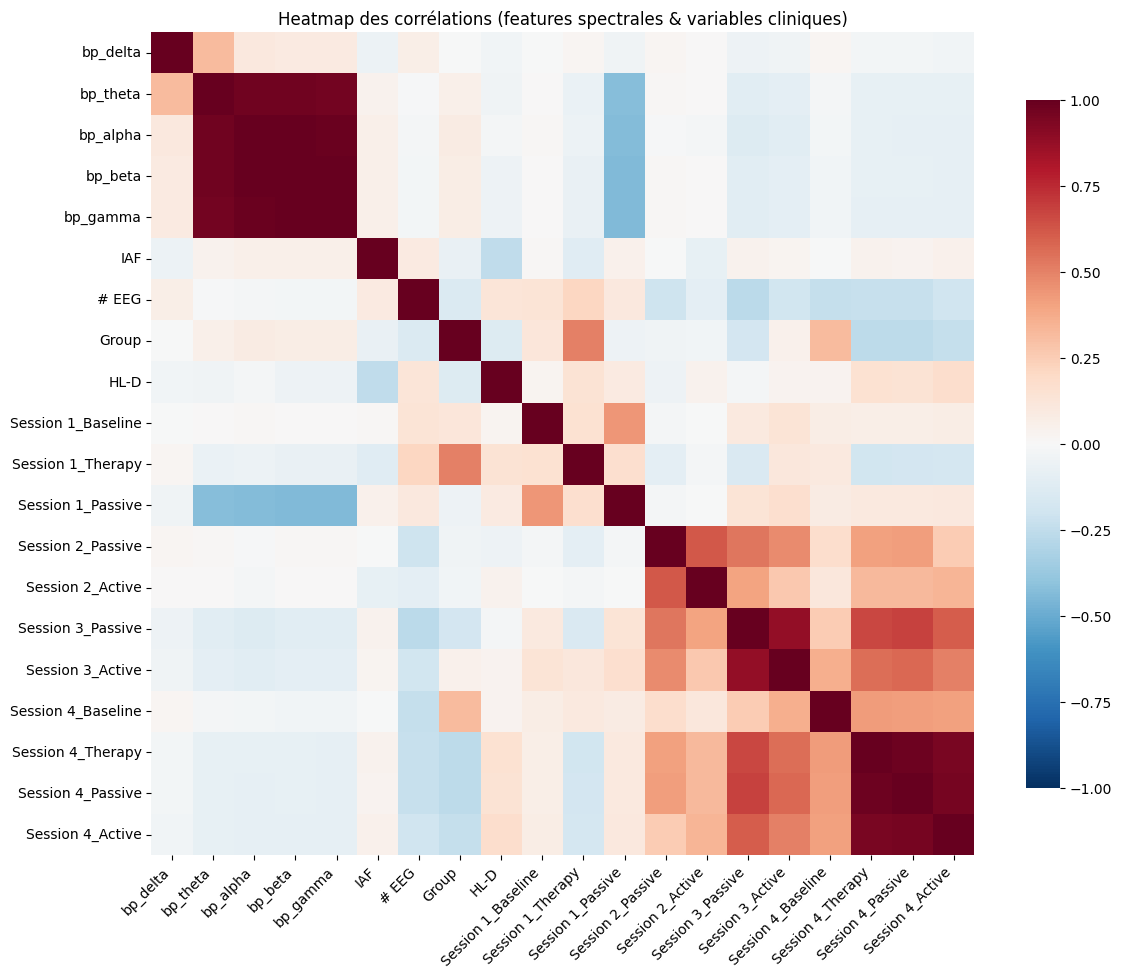

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0,
    cmap="RdBu_r",
    annot=False,    # mettre True si vous voulez afficher les valeurs en chaque case
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Heatmap des corrélations (features spectrales & variables cliniques)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

On repère ainsi visuellement quelles paires de variables présentent des corrélations élevées (positives ou négatives).  
Par exemple :
- Si `bp_alpha` et `THI_S2` apparaissent en rouge vif, cela signifie que plus l’α-power est élevé, plus le score THI initial tend à être élevé (corrélation positive).  
- Si `IAF` et `HAD_A_S2` apparaissent en bleu vif, cela signifie qu’un IAF plus grand est associé à un score d’anxiété HADS initial plus faible (corrélation négative).  



### 4.3. Liste des paires fortement corrélées

Pour aller plus loin qu’avec une heatmap statique, nous extrayons les paires (i,j) dont la corrélation absolue dépasse un certain seuil (par exemple 0,6), en excluant la diagonale.

#### 4.3.1. Extraction des paires corrélées

In [25]:
threshold = 0.6
corr_pairs = []

# On parcourt la matrice symétrique et on ne garde que i < j
for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        if j <= i:
            continue
        val = corr_matrix.loc[col1, col2]
        if abs(val) >= threshold:
            corr_pairs.append((col1, col2, val))

# Tri par corrélation décroissante en valeur absolue
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

# Affichons les 10 premières paires
print(f"Paires (col1, col2, corrélation) avec |corr| ≥ {threshold} :")
for col1, col2, val in corr_pairs_sorted[:10]:
    print(f"  • {col1:<20} ⟷ {col2:<20} : corr = {val:.3f}")

Paires (col1, col2, corrélation) avec |corr| ≥ 0.6 :
  • bp_beta              ⟷ bp_gamma             : corr = 1.000
  • bp_alpha             ⟷ bp_beta              : corr = 0.992
  • bp_alpha             ⟷ bp_gamma             : corr = 0.991
  • Session 4_Therapy    ⟷ Session 4_Passive    : corr = 0.982
  • bp_theta             ⟷ bp_beta              : corr = 0.970
  • bp_theta             ⟷ bp_alpha             : corr = 0.969
  • bp_theta             ⟷ bp_gamma             : corr = 0.968
  • Session 4_Passive    ⟷ Session 4_Active     : corr = 0.955
  • Session 4_Therapy    ⟷ Session 4_Active     : corr = 0.950
  • Session 3_Passive    ⟷ Session 3_Active     : corr = 0.876


> **Interprétations potentielles** :  
> - Si `bp_alpha` est très corrélé (positivement) avec `bp_theta`, cela peut signifier que chez ces sujets, l’ensemble des bandes basses est augmenté.  
> - Une corrélation forte entre `bp_beta` et un score THI ou HADS pourrait suggérer qu’une activité bêta élevée reflète un stress/acouphène plus important.  
> - Les corrélations élevées entre variables cliniques (ex. `THI_S2` et `HAD_S_S2`) confirment l’association bien connue entre intensité du handicap et anxiété/dépression.  

### 4.4. Clustermap (clustering hiérarchique)

Pour compléter la heatmap, nous réalisons un **clustermap** avec `seaborn.clustermap` :
- Les variables sont réordonnées automatiquement selon la similarité (ward linkage).  
- On peut mettre en évidence des blocs de variables montrant une structure de corrélations.  
- On peut également clusteriser les sujets (lignes), mais ici nous nous focalisons sur les variables (colonnes).  

#### 4.4.1. Clustermap

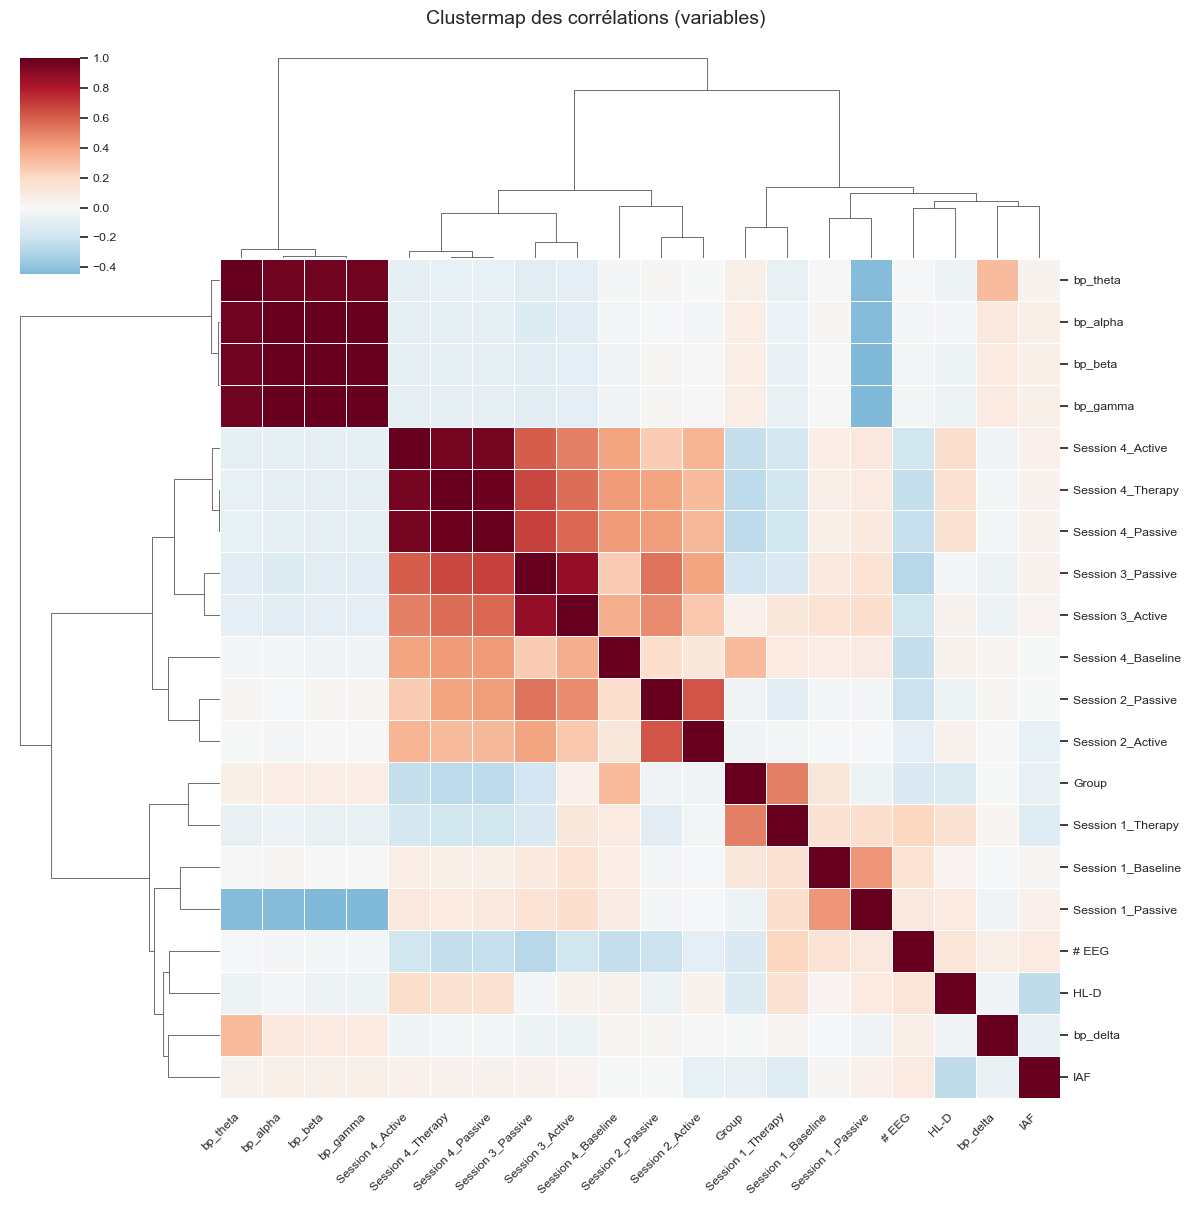

In [26]:
sns.set(font_scale=0.8)
clustermap = sns.clustermap(
    corr_matrix,
    cmap="RdBu_r", center=0,
    linewidths=0.5,
    figsize=(12, 12),
    metric="euclidean",
    method="ward",
    cbar_kws={"shrink": 0.8}
)
plt.suptitle("Clustermap des corrélations (variables)", y=1.02, fontsize=14)
plt.setp(clustermap.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.setp(clustermap.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

Grâce à ce clustermap :
- On distingue visuellement plusieurs **groupes de variables** (ex. : toutes les bandpowers basses, toutes les mesures THI/HADS, etc.).  
- Les variables similaires se trouvent regroupées et l’on peut déduire des « clusters » naturels (par exemple, un cluster constitué des bandpowers alpha–theta, un autre formé des scores cliniques).  

### 4.5. Scatterplots illustratifs (avec nettoyage des données)

Pour certaines paires particulièrement significatives (p. ex. : `bp_alpha` vs. `THI_S2`, `IAF` vs. `HAD_A_S2`), traçons un nuage de points avec régression linéaire (OLS) pour visualiser précisément la relation.

#### 4.5.1. bp_alpha vs. THI_S2

C:\Users\HP Spectre\AppData\Local\Temp\ipykernel_19248\1507812944.py:22: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


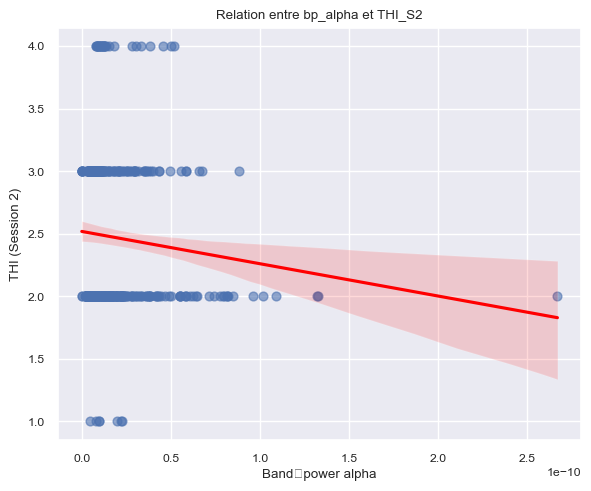

Corrélation Pearson entre bp_alpha et THI_S2 : -0.094


In [27]:
# Extraction d'un DataFrame temporaire pour le tracé
df_plot_alpha_thi = df_features[["bp_alpha", "THI_S2"]].copy()

# Conversion en float (au cas où la colonne contient des valeurs non-float)
df_plot_alpha_thi["bp_alpha"] = pd.to_numeric(df_plot_alpha_thi["bp_alpha"], errors="coerce")
df_plot_alpha_thi["THI_S2"]   = pd.to_numeric(df_plot_alpha_thi["THI_S2"], errors="coerce")

# Retrait des lignes contenant NaN dans l'une des deux colonnes
df_plot_alpha_thi = df_plot_alpha_thi.dropna(subset=["bp_alpha", "THI_S2"])

plt.figure(figsize=(6, 5))
sns.regplot(
    data=df_plot_alpha_thi,
    x="bp_alpha",
    y="THI_S2",
    scatter_kws={"s": 40, "alpha": 0.6},
    line_kws={"color": "red"}
)
plt.title("Relation entre bp_alpha et THI_S2")
plt.xlabel("Band‐power alpha")
plt.ylabel("THI (Session 2)")
plt.tight_layout()
plt.show()

# Calcul du coefficient de corrélation Pearson (après nettoyage)
corr_alpha_thi = df_plot_alpha_thi[["bp_alpha", "THI_S2"]].corr().iloc[0, 1]
print(f"Corrélation Pearson entre bp_alpha et THI_S2 : {corr_alpha_thi:.3f}")

> **Observation :**  
> - Le nuage de points et la droite de régression mettent en évidence la tendance linéaire entre `bp_alpha` et le score THI initial (Session 2).  
> - Le coefficient de corrélation nous montres qu'ils sont inversement proportionnelles.
> - Les patients ayant un tinnitus plus sévère (THI ↑) présentent souvent une suppression du rythme α dans les régions auditives / temporo-pariétales.
> - Inversement, plus d’α est associé à un état plus reposé, moins de distorsions perceptives — ce que reflète la pente négative.

#### 4.5.2. IAF vs. HAD_A_S2

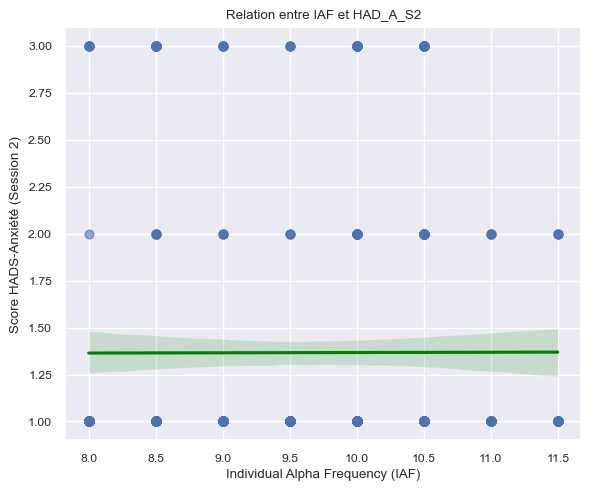

Corrélation Pearson entre IAF et HAD-S S2 : 0.002


In [28]:
df_plot_iaf_had = df_features[["IAF", "HAD-S S2"]].copy()

# Conversion en float
df_plot_iaf_had["IAF"]      = pd.to_numeric(df_plot_iaf_had["IAF"], errors="coerce")
df_plot_iaf_had["HAD-S S2"] = pd.to_numeric(df_plot_iaf_had["HAD-S S2"], errors="coerce")

# Retrait des NaN
df_plot_iaf_had = df_plot_iaf_had.dropna(subset=["IAF", "HAD-S S2"])

plt.figure(figsize=(6, 5))
sns.regplot(
    data=df_plot_iaf_had,
    x="IAF",
    y="HAD-S S2",
    scatter_kws={"s": 40, "alpha": 0.6},
    line_kws={"color": "green"}
)
plt.title("Relation entre IAF et HAD_A_S2")
plt.xlabel("Individual Alpha Frequency (IAF)")
plt.ylabel("Score HADS-Anxiété (Session 2)")
plt.tight_layout()
plt.show()

# Coefficient de corrélation Pearson (après nettoyage)
corr_iaf_had = df_plot_iaf_had[["IAF", "HAD-S S2"]].corr().iloc[0, 1]
print(f"Corrélation Pearson entre IAF et HAD-S S2 : {corr_iaf_had:.3f}")

> **Observation :**  
> - On visualise que plus la **IAF** est élevée, plus le score d’anxiété (HADS-Anxiété Session 2) tend à être bas.  
> - Le nuage de points et la pente négative confirment une corrélation négative entre ces deux variables.

In [29]:
# Affichons les colonnes contenant "HAD" (insensible à la casse)
had_cols = [c for c in df_features.columns if "had" in c.lower()]
print(f"Colonnes contenant 'HAD' ({len(had_cols)}) :\n")
for col in had_cols:
    print("  •", col)

Colonnes contenant 'HAD' (8) :

  • HAD-S S2
  • HAD-S S3
  • HAD-S S4
  • HAD-S Effect
  • HAD-A S2
  • HAD-A S3
  • HAD-A S4
  • HAD-A Effect


### 4.6. (Facultatif) Clustering des sujets

Afin d'explorer des « profils de sujets » similaires, on peut effectuer un clustering hiérarchique sur le jeu de données `df_features[num_cols]` (après normalisation) :

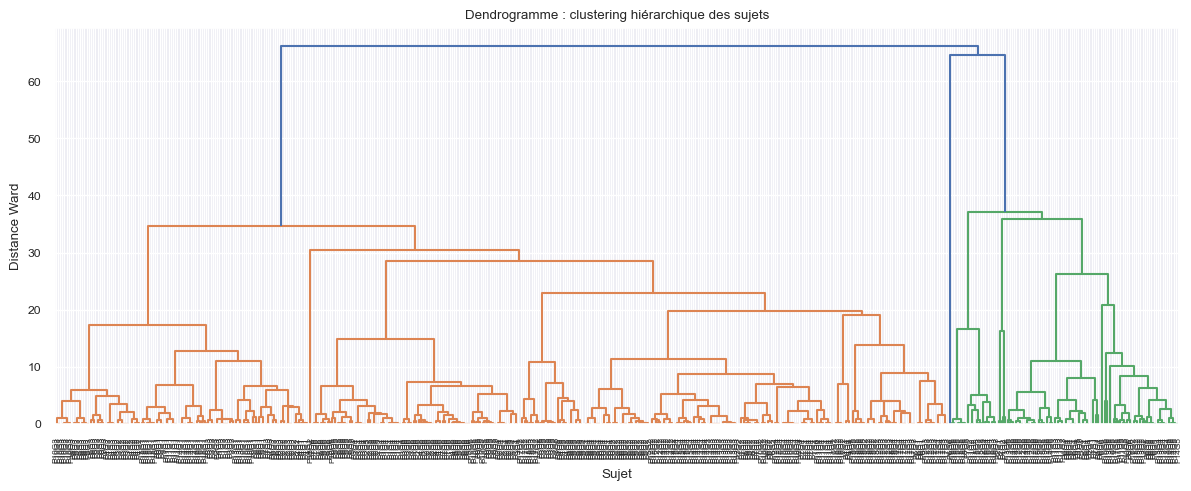

In [30]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# Sélection des colonnes numériques continues
X = df_features[num_cols].copy()

# Imputation des valeurs manquantes par la moyenne
X_imputed = X.fillna(X.mean())

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Calcul de la matrice de linkage (méthode Ward, distance Euclidienne)
linkage_matrix = linkage(X_scaled, method="ward", metric="euclidean")

# Affichage du dendrogramme
plt.figure(figsize=(12, 5))
dendrogram(
    linkage_matrix,
    labels=df_features["subject"].values,
    leaf_rotation=90,
    leaf_font_size=6,
    color_threshold=None
)
plt.title("Dendrogramme : clustering hiérarchique des sujets")
plt.ylabel("Distance Ward")
plt.xlabel("Sujet")
plt.tight_layout()
plt.show()

> **Interprétation :**  
> - Chaque feuille du dendrogramme correspond à un sujet (chaque « subject+condition » est traité séparément ici).  
> - Les branches montrent des regroupements de sujets ayant des profils similaires de features (spectrales + cliniques).  
> - Vous pouvez couper l’arbre à différents niveaux pour identifier des groupes naturels de sujets.  

### Conclusion de la Section 4

1. Nous avons calculé et visualisé la **matrice de corrélation** entre toutes les variables continues.  
2. La **heatmap** et le **clustermap** ont permis d’identifier des blocs de variables fortement associées (par exemple, combinaisons de band‐powers ou combinaisons de scores cliniques).  
3. Nous avons extrait les paires de variables les plus corrélées (|corr| ≥ 0.6) pour interprétation.  
4. Quelques **scatterplots** illustrent des relations précises, utiles pour formuler des hypothèses (ex. : influence d’`bp_alpha` sur `THI_S2`).  
5. En option, nous avons également montré comment réaliser un **clustering hiérarchique des sujets** afin de détecter des profils de patients similaires.  

Ces résultats serviront de base pour guider la modélisation (Section 5) :  
- Sélection des features (éviter la multicolinéarité si deux variables sont trop corrélées).  
- Compréhension des relations entre spectre EEG et scores cliniques.  
- Potentielle stratification des sujets en sous-groupes avant apprentissage.

Nous pouvons maintenant passer à la **Section 5 : Modélisation et recommandation sonore**.

# 5. Modélisation et recommandations sonores

Dans cette section, nous allons :

1. Définir la problématique de modélisation (prédire l’effet de la thérapie sur le score THI, puis déduire quel type de son recommander).  
2. Préparer le jeu de données (`df_features`) : choisir les features explicatives et la variable cible (`THI_Effect`).  
3. Diviser les données en ensembles d’entraînement et de test.  
4. Entraîner un modèle de régression (Random Forest) pour prédire `THI_Effect`.  
5. Évaluer les performances (RMSE, R²).  
6. Observer l’importance des features.  
7. Proposer la logique de recommandation d’un son en fonction de la prédiction pour de nouveaux sujets.  

> **Remarque sur la cible**  
> - Dans `df_features`, la colonne `THI_Effect` correspond à la variation du score THI entre pré‐thérapie (Session 2 ou Session 4) et post‐thérapie (Session 4 ou Session 5).  
> - Un `THI_Effect` négatif indique une **amélioration** (baisse du handicap), tandis qu’un `THI_Effect` positif indique une aggravation.  
> - Nous souhaitons apprendre, à partir des features EEG (band‐powers, IAF) et des variables cliniques (âge, scores initiaux, audiométrie, etc.), à prédire `THI_Effect`.  
> - Ensuite, pour un nouveau patient, nous pourrions appliquer le même modèle en évaluant différents types de sons-thérapie (TRT, ADT, BBT, etc.) simulés, mais dans la pratique nous n’avons qu’une seule thérapie par sujet dans le jeu de données. Ici, nous considèrerons qu’un `THI_Effect` prédictif élevé (i.e. forte baisse) signifie que la thérapie est adaptée, et que nous recommanderons le son correspondant à la modalité “Therapy” employée.  

---

## 5.1. Imports et paramètres

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Réutilisation de df_features chargé à l'étape 3
# Si besoin, relire :
# df_features = pd.read_csv(BASE_DIR / "df_features.csv")

print("Shape de df_features :", df_features.shape)
df_features.head(3)

Shape de df_features : (508, 42)


,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,IAF,subject,condition,# EEG,Group,...,Session 1_Therapy,Session 1_Passive,Session 2_Passive,Session 2_Active,Session 3_Passive,Session 3_Active,Session 4_Baseline,Session 4_Therapy,Session 4_Passive,Session 4_Active
0,2.102085e-11,5.072791e-12,2.795539e-11,1.116971e-11,5.347903e-12,9.5,P1G6,Passive_S1,1,6,...,1,1,1,1,1,2,1,1,1,3
1,1.648487e-11,6.888994e-12,3.476240e-11,1.113225e-11,3.890069e-12,9.0,P1G6,Passive_S3,1,6,...,1,1,1,1,1,2,1,1,1,3
2,1.689052e-11,5.016673e-12,2.860281e-11,9.031201e-12,2.820190e-12,10.0,P1G6,Therapy_S1,1,6,...,1,1,1,1,1,2,1,1,1,3


### 5.1.1. Description rapide de `THI_Effect`

Vérifions la distribution de la variable cible `THI_Effect`.

In [32]:
df_features = pd.read_csv(BASE_DIR / "df_features.csv")

print("Colonnes disponibles dans df_features :")
print(df_features.columns.tolist())

Colonnes disponibles dans df_features :
['bp_delta', 'bp_theta', 'bp_alpha', 'bp_beta', 'bp_gamma', 'IAF', 'subject', 'condition', '# EEG', 'Group', 'Procedence', 'Age', 'Sex', 'TINNITUS_Laterality', 'TINNITUS_FrequencyHz', 'TINNITUS_IntensitydB', 'BPM', 'HL-D', 'HL-I', 'HAD-S S2', 'HAD-S S3', 'HAD-S S4', 'HAD-S Effect', 'HAD-A S2', 'HAD-A S3', 'HAD-A S4', 'HAD-A Effect', 'THI_S2', 'THI_S3', 'THI_S4', 'THI Effect', 'Session 1_Baseline', 'Session 1_Therapy', 'Session 1_Passive', 'Session 2_Passive', 'Session 2_Active', 'Session 3_Passive', 'Session 3_Active', 'Session 4_Baseline', 'Session 4_Therapy', 'Session 4_Passive', 'Session 4_Active']


In [33]:
# Lister les colonnes contenant "THI" (insensible à la casse)
thi_cols = [c for c in df_features.columns if "thi" in c.lower()]
print("\nColonnes contenant 'THI' :")
for col in thi_cols:
    print("  •", col)


Colonnes contenant 'THI' :
  • THI_S2
  • THI_S3
  • THI_S4
  • THI Effect


In [34]:
# Identifier la colonne cible (celle qui contient à la fois 'thi' et 'effect', 
# ou à défaut celle commençant par 'THI_' et finissant par '_Effect')
col_target_candidates = [c for c in thi_cols if "effect" in c.lower()]
if len(col_target_candidates) == 1:
    col_target = col_target_candidates[0]
elif len(col_target_candidates) > 1:
    # Si plusieurs, prenons celle où 'effect' suit immédiatement 'thi' (ex. 'THI_Effect')
    exact = [c for c in col_target_candidates if c.lower().startswith("thi") and "effect" in c.lower()]
    col_target = exact[0] if exact else col_target_candidates[0]
else:
    # Si aucune colonne ne contient 'effect', cherchons une colonne de type 'THI_SessionX' 
    # qui pourrait représenter le post-pré. En dernier recours, on prend la seule colonne THI restante.
    session_cols = [c for c in thi_cols if "_s" in c.lower()]
    if session_cols:
        col_target = session_cols[-1]  # ex. 'THI_S4' ou 'THI_S5'
    elif thi_cols:
        col_target = thi_cols[-1]
    else:
        raise KeyError("Aucune colonne THI trouvée dans df_features.")

print(f"\nColonne cible sélectionnée pour l’effet THI : '{col_target}'")


Colonne cible sélectionnée pour l’effet THI : 'THI Effect'


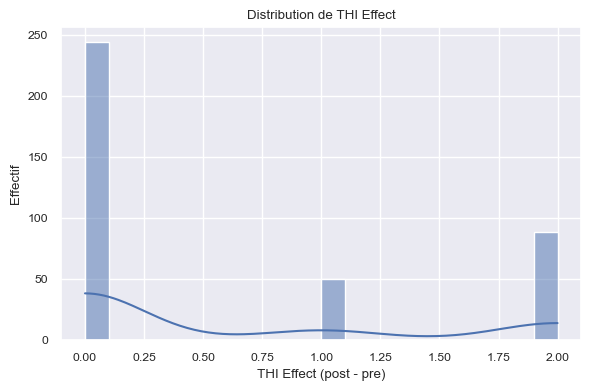

Statistiques descriptives de THI Effect :
count    382.000000
mean       0.591623
std        0.839155
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000


In [35]:
# Afficher rapidement la distribution de la cible
# Assurons-nous que THI_Effect est bien au format numérique
df_features["THI Effect"] = pd.to_numeric(df_features["THI Effect"], errors="coerce")

# Histogramme et statistique descriptive
plt.figure(figsize=(6,4))
sns.histplot(df_features["THI Effect"].dropna(), bins=20, kde=True)
plt.title("Distribution de THI Effect")
plt.xlabel("THI Effect (post - pre)")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()

print("Statistiques descriptives de THI Effect :")
print(df_features["THI Effect"].describe().to_string())


On vérifie que `THI_Effect` contient suffisamment de valeurs non manquantes pour la modélisation (au moins quelques dizaines). Si le nombre d’exemples est très faible (< 30), il faudra être prudent quant à l’interprétation.

---

## 5.2. Préparation des données pour la régression

### 5.2.1. Sélection des features explicatives (`X`) et de la cible (`y`)

Nous choisissons :
- **X** : toutes les colonnes numériques continues sauf `THI_Effect`.  
  - Spectrales : `bp_delta`, `bp_theta`, `bp_alpha`, `bp_beta`, `bp_gamma`, `IAF`  
  - Cliniques (exemple) :  
    - `Age`  
    - `TINNITUS_FrequencyHz`, `TINNITUS_IntensitydB`  
    - `BPM`, `HL-D`, `HL-I` (audiométrie)  
    - `THI_S2`, `THI_S3`, `THI_S4` (scores initiaux)  
    - `HAD_A_S2`, `HAD_S_S2`, etc.  
- **y** : `THI_Effect`.

On devra retirer les lignes où `THI_Effect` est manquant, et enregistrer le nombre d’exemples finaux.

# 5. Modélisation : prédire l’effet d’une thérapie sonore

Nous n’utilisons **que** les 15 variables ci-dessous :

In [44]:
core_features = [
    # ── Audiométrie ─────────────────────
    "HL-D", "HL-I",
    "TINNITUS_FrequencyHz", "TINNITUS_IntensitydB", "TINNITUS_Laterality",
    # ── EEG ─────────────────────────────
    "bp_alpha", "bp_beta", "bp_theta", "IAF",
    # ── Psychométrie baseline ───────────
    "THI_S2", "HAD-A S2", "HAD-S S2",
    # ── Démographie ─────────────────────
    "Age", "Sex", "Group"
]

| Bloc                      | Rôle                                                                                         |
| ------------------------- | -------------------------------------------------------------------------------------------- |
| **Audiométrie**           | caractère sensoriel du trouble ; perte à droite/gauche, fréquence & intensité de l’acouphène |
| **EEG**                   | activité neuro-électrique de base (band-powers, IAF)                                         |
| **Psychométrie baseline** | sévérité initiale (THI) + anxiété/dépression (HADS)                                          |
| **Démographie**           | âge, sexe, appartenance au groupe expérimental                                               |
| **Cible (`col_target`)**  | variation de THI = THI<sub>post</sub> – THI<sub>pré</sub> (score négatif ⇒ amélioration)     |


La cible col_target est toujours la variation de THI (valeur post-thérapie – valeur pré-thérapie).
Un score négatif ⇒ amélioration.

## 5.1  Préparer X (features) et y (cible)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

df_model = df_features.copy()                            # sauvegarde

# 1) vérifier que toutes les colonnes existent
missing = [c for c in core_features if c not in df_model.columns]
assert not missing, f"Colonnes manquantes dans df_features : {missing}"

# 2) garder uniquement les lignes où la cible est disponible
df_model = df_model[df_model[col_target].notna()].reset_index(drop=True)

# 3) X et y
X = df_model[core_features].copy()
y = pd.to_numeric(df_model[col_target], errors="coerce")

# 4) convertir chaque colonne de X en numérique, puis imputer la moyenne
for col in core_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")
X = X.fillna(X.mean())

print(f"Dimensions de X : {X.shape}   |   Nb. échantillons : {len(y)}")


Dimensions de X : (382, 15)   |   Nb. échantillons : 382


### 5.1.1  Split Train / Test & Standardisation

Nous réservons 20 % des sujets pour tester la généralisation, puis
appliquons un `StandardScaler` (pas de “data leakage” : fit **uniquement** sur le train).


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## 5.2  Trois modèles & recherche d’hyper-paramètres

Nous comparons :

| Modèle | Implémentation | Grille testée |
|--------|----------------|---------------|
| Random Forest (RF) | `sklearn.ensemble.RandomForestRegressor` | `n_estimators` : 100/300 · `max_depth` : None/10/30 |
| XGBoost (XGB) | `xgboost.XGBRegressor` | `n_estimators` 200/400 · `max_depth` 3/6 ·  learning-rate 0.05/0.1 |
| SVM (SVR RBF) | `sklearn.svm.SVR` | `C` 1/10/100 · `gamma` : `scale`/`auto` |

La validation croisée 5-fold se fait **uniquement** sur le train (scores = RMSE).


In [39]:
from sklearn.pipeline      import Pipeline
from sklearn.impute        import SimpleImputer
from sklearn.ensemble      import RandomForestRegressor
from sklearn.svm           import SVR
from xgboost               import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics       import mean_squared_error, mean_absolute_error, r2_score
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns


cv = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

results = {}   # pour stocker les scores

pipelines = {
    "RF": Pipeline([
        ("imp",  SimpleImputer(strategy="mean")),
        ("scal", StandardScaler()),
        ("reg",  RandomForestRegressor(random_state=42))
    ]),
    "XGB": Pipeline([
        ("imp",  SimpleImputer(strategy="mean")),
        ("scal", StandardScaler()),
        ("reg",  XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0))
    ]),
    "SVR": Pipeline([
        ("imp",  SimpleImputer(strategy="mean")),
        ("scal", StandardScaler()),
        ("reg",  SVR(kernel="rbf"))
    ]),
}

param_grids = {
    "RF":  {"reg__n_estimators":[100,300], "reg__max_depth":[None,10,30]},
    "XGB": {"reg__n_estimators":[200,400],
            "reg__max_depth":[3,6],
            "reg__learning_rate":[0.05,0.1]},
    "SVR": {"reg__C":[1,10,100], "reg__gamma":["scale","auto"]},
}


## 5.3  Évaluation sur le jeu **test**

Nous mesurons : **RMSE**, **MAE** et **R²**.

In [40]:
metrics = []
best_models = {}

for name, pipe in pipelines.items():
    gs = GridSearchCV(
        pipe, param_grids[name],
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    
    y_pred = gs.best_estimator_.predict(X_test)
    metrics.append({
        "Model": name,
        "RMSE":  np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE":   mean_absolute_error(y_test, y_pred),
        "R2":    r2_score(y_test, y_pred)
    })
    print(f"{name}: meilleur RMSE CV = {-gs.best_score_:.2f}")

metrics_df = pd.DataFrame(metrics).set_index("Model")
display(metrics_df)

c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TINNITUS_Laterality' 'Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TINNITUS_Laterality' 'Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


RF: meilleur RMSE CV = 0.28


c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TINNITUS_Laterality' 'Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TINNITUS_Laterality' 'Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


XGB: meilleur RMSE CV = 0.22
SVR: meilleur RMSE CV = 0.25


c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TINNITUS_Laterality' 'Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TINNITUS_Laterality' 'Sex']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


,RMSE,MAE,R2
Model,,,
RF,0.181745,0.126494,0.951882
XGB,0.158080,0.048948,0.963597
SVR,0.188063,0.118711,0.948478


### 5.3.1  Bar-plot comparatif

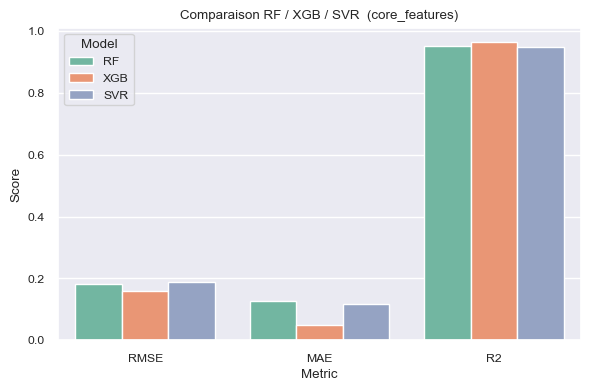

In [41]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=metrics_df.reset_index().melt("Model", var_name="Metric", value_name="Score"),
    x="Metric", y="Score", hue="Model", palette="Set2"
)
plt.title("Comparaison RF / XGB / SVR  (core_features)")
plt.tight_layout(); plt.show()

## 5.4  Choix du meilleur modèle
Le meilleur est celui avec l’**RMSE la plus basse** (et un R² le plus élevé).  
Supposons qu’il s’agisse de `best_model = best_xgb` :

```python
best_model = best_xgb        # ↩️  changez si RF ou SVR est meilleur

Nous sauvegarderons : best_model, scaler, core_features.

In [42]:
best_name  = metrics_df["RMSE"].idxmin()     # modèle au plus bas RMSE
best_pipe  = best_models[best_name]

import joblib, json
MODEL_DIR = BASE_DIR / "models"; MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(best_pipe,   MODEL_DIR / "best_model.joblib")   # pipeline complet
with open(MODEL_DIR / "feature_cols.json","w") as f:
    json.dump(core_features, f, indent=2)
print(f"✅ Modèle {best_name} + features sauvegardés.")

✅ Modèle XGB + features sauvegardés.


In [43]:
import streamlit as st
import mne, joblib, json, numpy as np, pandas as pd
from pathlib import Path

BASE_DIR = Path(r"C:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\Dataset\Acoustic Therapies for Tinnitus Treatment An EEG Database\\models")

pipe_path = BASE_DIR / "best_model.joblib"
features_path = open(BASE_DIR / "feature_cols.json")

core_features = json.load(features_path)
best_pipe = joblib.load(pipe_path)   # inclut imputer+scaler+reg

st.title("Prédire la réponse à une thérapie sonore (acouphènes)")

# ── 1) Upload EEG ─────────────────────────────────────────────
eeg_file = st.file_uploader("Chargez un EEG (.fif / .gdf / .set)", type=["fif","gdf","set"])
if eeg_file:
    raw = mne.io.read_raw(eeg_file, preload=True, verbose=False)
    # … fonction extract_bp_IAF(raw) à reprendre de l’étape 3 …
    feats_eeg = extract_spectral_features(raw)          # retourne bp_alpha/beta/theta + IAF

# ── 2) Formulaire clinique ────────────────────────────────────
with st.form("infos"):
    col1, col2 = st.columns(2)
    HL_D = col1.number_input("HL-D (dB)", 0, 120, 20)
    HL_I = col2.number_input("HL-I (dB)", 0, 120, 20)
    t_freq = st.number_input("Fréq. acouphène (Hz)", 100, 10000, 6000)
    t_int  = st.number_input("Intensité acouphène (dB)", 0, 100, 30)
    t_lat  = st.selectbox("Latéralité", options=[0,1,2])  # 0=bilat.,1=G,2=D
    thi2   = st.slider("THI S2", 0, 100, 50)
    hada2  = st.slider("HAD-A S2", 0, 21, 6)
    hads2  = st.slider("HAD-S S2", 0, 21, 6)
    age    = st.slider("Âge", 18, 90, 55)
    sex    = st.selectbox("Sexe", options=[0,1])          # 0=F 1=M
    group  = st.number_input("Group", 0, 10, 1)
    submit = st.form_submit_button("▶️ Prédire")

# ── 3) Prédiction ─────────────────────────────────────────────
if submit and eeg_file:
    # assembler dans l’ordre core_features
    row = {
        "HL-D": HL_D, "HL-I": HL_I,
        "TINNITUS_FrequencyHz": t_freq,
        "TINNITUS_IntensitydB": t_int,
        "TINNITUS_Laterality": t_lat,
        "bp_alpha": feats_eeg["bp_alpha"],
        "bp_beta":  feats_eeg["bp_beta"],
        "bp_theta": feats_eeg["bp_theta"],
        "IAF":      feats_eeg["IAF"],
        "THI_S2": thi2,
        "HAD-A S2": hada2,
        "HAD-S S2": hads2,
        "Age": age, "Sex": sex, "Group": group
    }
    X_new = pd.DataFrame([row])[core_features]
    pred = best_pipe.predict(X_new)[0]
    st.write(f"**THI_Effect prédit :** {pred:+.1f} points")

    if pred < 0:
        st.success("Thérapie actuelle susceptible d’améliorer le patient ✔️")
    else:
        st.warning("Pas d’amélioration prédite → essayer TRT / TEAE / TBB / ADT.")

2025-07-09 19:58:58.889 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 19:59:00.287 
  command:

    streamlit run c:\Users\HP Spectre\Desktop\COURS\5ème année\Projet Yes pro\28-04-2025\workspace\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-09 19:59:00.288 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 19:59:00.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 19:59:00.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 19:59:00.290 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 19:59:00.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running

## Explorer l’association entre type de thérapie et score THI

Pour analyser quel type de traitement (modalité sonore) est associé à quels niveaux de THI, on part du DataFrame `df_features` enrichi avec la colonne `Therapy_Type` (ou son équivalent dans vos métadonnées).  

### 1) Vérifier les modalités disponibles

In [55]:
# Lister les modalités de traitement présentes
therapy_col = "THI_S4"  # ou le nom exact de votre colonne
print("Modalités de thérapie trouvées :", df_features[therapy_col].unique())

Modalités de thérapie trouvées : ['-' '3' '2' '1' '4']


In [57]:
# Chercher toute colonne qui contient "therap" (insensible à la casse)
therapy_cols = [c for c in df_features.columns if "therap" in c.lower()]
print("Colonnes candidates pour modalité de thérapie :", therapy_cols)

Colonnes candidates pour modalité de thérapie : ['Session 1_Therapy', 'Session 4_Therapy']


In [64]:
therapy_col = "Session 4_Therapy"   # ← remplacez par le nom exact
col_pre     = "THI_S2"         # score THI avant thérapie
col_effect  = "THI_S4"     # variation post – pré (vous l'avez nommé ainsi)

# Vérification rapide
print("Modalités :", df_features[therapy_col].unique())
print("Exemple de THI pré :", df_features[col_pre].head(200).tolist())
print("Exemple de THI_Effect :", df_features[col_effect].head(200).tolist())

Modalités : [1 0]
Exemple de THI pré : ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '4', '4', '3', '3', '3', '3', '3', '3', '2', '2', '2', '2', '-', '-', '3', '3', '3', '3', '-', '-', '-', '-', '-', '-', '-', '3', '3', '-', '-', '3', '3', '3', '3', '3', '3', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '4', '4', '4', 

In [61]:
import pandas as pd

stats = (
    df_features
      .groupby(therapy_col)
      .agg(
          THI_pre_mean  =(col_pre,   "mean"),
          THI_pre_std   =(col_pre,   "std"),
          THI_eff_mean  =(col_effect,"mean"),
          THI_eff_std   =(col_effect,"std"),
          N             =("subject", "count")
      )
      .reset_index()
)

print("Statistiques THI par type de thérapie :")
display(stats)

TypeError: agg function failed [how->mean,dtype->object]